# Incomplete Data 

Creating accurate predictions is one of the most valuable skills in the job market today. Statisticians, economists, and data scientists use data gathered from specific populations in order to make predictions about what behaviors are likely to occur in the future, or what the truth is about what has already occured. Through computational and statistical techniques, we can make _statistical inferences_ to draw conclusions from data that are often incomplete.

As far as estimations of parameters that already exist, having full population data would mean that our questions about that population are answered. But because the cost of gathering full population would, usually, outweigh the benefit of having perfectly accurate data, we are okay with using incomplete samples to make inferences. 

## Are Mutual Funds better than Broad-market index funds? 

The term “index fund” refers to the investment approach of a fund. Specifically, it is a fund that that aims to match the performance of a particular market index, such as the S&P 500 or Russell 2,000. The index fund simply tries to match the market. This differs from a more actively managed fund, in which investments are picked by a fund manager in an attempt to beat the market. The age old question is: are the fees payed to an actively-managed mutual fund worth it? 

We could simply compare the mean return from a given date range for a mutual fund and compare it to the S&P500s mean return from the same time interval, and see which is higher. But the fact that mutual funds have a finite number of time intervals which we can sample means we cannnot rule out the possibility that higher or lower returns from the fund were a result of random variation, and not an indicator of the true quality of the fund. The S&P500 is , essentially, the market. We know all of the information we need about it, because it isnt a sample. The mutual fund data, on the other hand, is incomplete. So, we need to analyze the two funds using statistical techniques which account for random variation that is possible from incomplete data. 

We would like to ananlyze which(if any) mutual funds have out-performed the market, fees included. To start, we read the CSV downloaded from [Stock Market MBA](https://stockmarketmba.com/listoftop100activelymanagedusstockmutualfunds.php), which shows the 100 largest actively-managed mutual funds in the US. 

In [1]:
import numpy as np
import pandas as pd

mutual_fund_data = pd.read_csv("Top100MutualFunds.csv")
to_drop = ["Category2", "Category1","Category3", "Morningstar Category", "Morningstar Rating","Current yield", "Action"]
mutual_fund_data = mutual_fund_data.drop(columns=to_drop)

In [2]:
mutual_fund_data

,Symbol,Name,Market cap,Fees
0,AGTHX,American Funds The Growth Fund of America Class A,"$138,592,080,000",0.62%
1,FCNTX,Fidelity Contrafund Fund,"$121,762,870,000",0.74%
2,CWMAX,American Funds Washington Mutual Investors Fun...,"$113,300,000,000",0.63%
3,CWMCX,American Funds Washington Mutual Investors Fun...,"$113,300,000,000",1.40%
4,CWMEX,American Funds Washington Mutual Investors Fun...,"$113,300,000,000",0.87%
...,...,...,...,...
95,FDTRX,Franklin DynaTech Fund Class R6,"$9,600,000,000",0.51%
96,FDYZX,Franklin DynaTech Fund Advisor Class,"$9,600,000,000",0.62%
97,BBVLX,Bridge Builder Large Cap Value Fund,"$9,500,000,000",0.25%
98,PEYAX,Putnam Large Cap Value Fund Class A,"$9,393,340,000",0.91%


In [3]:
import pandas_datareader as web
import datetime as dt

mutual_fund_dict = {}
symbols = mutual_fund_data["Symbol"].iloc[0:25]
# will only analyze the first 25 funds for now, but this should illustrate how to do it for any fund 
start= dt.datetime(1970, 1, 1)
end = dt.datetime.today()
for symbol in symbols: 
    #pull mutual fund data for the longest timeframe avaliable, and cpnvert to monthly percent change data 
    fund_data = web.DataReader(symbol, 'yahoo', start, end)#["Adj Close"].resample('M').first().pct_change()
    mutual_fund_dict[symbol] = fund_data
    

In [4]:
mutual_fund_dict

{'AGTHX':                  High        Low       Open      Close  Volume  Adj Close
 Date                                                                     
 1980-01-02   3.440000   3.440000   3.440000   3.440000     0.0   0.669570
 1980-01-03   3.500000   3.500000   3.500000   3.500000     0.0   0.681248
 1980-01-04   3.500000   3.500000   3.500000   3.500000     0.0   0.681248
 1980-01-07   3.590000   3.590000   3.590000   3.590000     0.0   0.698766
 1980-01-08   3.630000   3.630000   3.630000   3.630000     0.0   0.706551
 ...               ...        ...        ...        ...     ...        ...
 2022-01-24  65.430000  65.430000  65.430000  65.430000     0.0  65.430000
 2022-01-25  64.080002  64.080002  64.080002  64.080002     0.0  64.080002
 2022-01-26  63.990002  63.990002  63.990002  63.990002     0.0  63.990002
 2022-01-27  63.090000  63.090000  63.090000  63.090000     0.0  63.090000
 2022-01-28  64.589996  64.589996  64.589996  64.589996     0.0  64.589996
 
 [10611 rows x

To start, you formulate your __hypotheses__. These are mutually exclusive, falsifiable statements. Only one can be true, and one of them will be true. We create these two hypotheses: 

- The _null_ hypothesis $H_o$: The true means of the the sample populations do not differ.
- The _alternate_ hypothesis $H_a$: The true means of the sample populations do differ.

### 4 Steps of Hypothesis Testing

All hypotheses are tested using a four-step process:

1. State the two hypotheses so that only one can be right. 
2. Formulate an analysis plan, which outlines how the data will be evaluated.
3. Carry out the plan and physically analyze the sample data.
4. Analyze the results and either reject the null hypothesis, or state that the null hypothesis is plausible, given the data.

Hypothesis testing can be done mentally. It would be burdensome to have to state your _null_ and _alternate_ hypotheses, and run through these four steps explicitly every time you made a predictive computer model. The point is that in means testing, there is a clear process and result that deliniates "Yes, the true means of these samples are different" and "No, they're not significantly different"

In the case of us determining the efficacy of our company's marketing campaign, these are our hypotheses: 

- $H_o$: There is no difference between the mutual fund's and S&P500's average monthly return. 
- $H_a$: The mutual funds have a higher mean gain than the S&P500. 

In [5]:
keys = mutual_fund_dict.keys()
keys

dict_keys(['AGTHX', 'FCNTX', 'CWMAX', 'CWMCX', 'CWMEX', 'CWMFX', 'AIVSX', 'AWSHX', 'ANCFX', 'AMCFX', 'CAFAX', 'CAFCX', 'CAFEX', 'CAFFX', 'FMACX', 'TRBCX', 'AFMFX', 'AMRFX', 'CMLAX', 'CMLCX', 'CMLEX', 'CMLFX', 'FDGRX', 'FBGRX', 'AMCPX'])

In [6]:
# create empty dictionary to hold average yearly gain for each mutual fund 
monthly_returns_dict = {}
keys = mutual_fund_dict.keys()
for key in keys:
    # for each mutual fund, find average yearly gain
    monthly_returns_dict[key] = mutual_fund_dict[key]["Adj Close"].resample("Y").first().pct_change().mean()
monthly_returns_dict

{'AGTHX': 0.13260423356068654,
 'FCNTX': 0.13973352177769022,
 'CWMAX': 0.098016678714484,
 'CWMCX': 0.08965914588719956,
 'CWMEX': 0.09372476577237138,
 'CWMFX': 0.09744698156459285,
 'AIVSX': 0.10438842505105939,
 'AWSHX': 0.12001906520935163,
 'ANCFX': 0.12702928042570802,
 'AMCFX': 0.13831083841951583,
 'CAFAX': 0.11125520943624445,
 'CAFCX': 0.1033520738961963,
 'CAFEX': 0.10670996028485383,
 'CAFFX': 0.11171992670241122,
 'FMACX': 0.1771834208944636,
 'TRBCX': 0.13614414959706425,
 'AFMFX': 0.13384030820244097,
 'AMRFX': 0.10967890583919535,
 'CMLAX': 0.09268938063233144,
 'CMLCX': 0.08390032999583322,
 'CMLEX': 0.08685563166191637,
 'CMLFX': 0.09169874438540804,
 'FDGRX': 0.16284698276112308,
 'FBGRX': 0.15053008444772017,
 'AMCPX': 0.10518697939837716}

In [7]:
yearly_returns_dict = {}
for key in keys:
    # for each mutual fund, find average yearly gain
    yearly_returns_dict[key] = mutual_fund_dict[key]["Adj Close"].resample("Y").first().pct_change().dropna()

In [8]:
yearly_returns_dict

{'AGTHX': Date
 1981-12-31    0.453457
 1982-12-31   -0.020501
 1983-12-31    0.212065
 1984-12-31    0.230471
 1985-12-31   -0.084010
 1986-12-31    0.187306
 1987-12-31    0.119006
 1988-12-31    0.004739
 1989-12-31    0.099592
 1990-12-31    0.189245
 1991-12-31   -0.111222
 1992-12-31    0.287670
 1993-12-31    0.060904
 1994-12-31    0.119483
 1995-12-31   -0.021832
 1996-12-31    0.259153
 1997-12-31    0.130284
 1998-12-31    0.286847
 1999-12-31    0.309306
 2000-12-31    0.457554
 2001-12-31    0.047906
 2002-12-31   -0.094836
 2003-12-31   -0.199960
 2004-12-31    0.294167
 2005-12-31    0.106285
 2006-12-31    0.175347
 2007-12-31    0.087448
 2008-12-31    0.103125
 2009-12-31   -0.366795
 2010-12-31    0.326132
 2011-12-31    0.115143
 2012-12-31   -0.038973
 2013-12-31    0.209380
 2014-12-31    0.298453
 2015-12-31    0.102897
 2016-12-31    0.035109
 2017-12-31    0.115083
 2018-12-31    0.266060
 2019-12-31   -0.042375
 2020-12-31    0.293621
 2021-12-31    0.347986
 

These values will be compared to the monthly returns of the stock market: 

In [9]:
from datlib.stats import *

sp500 = web.DataReader('^GSPC', 'yahoo', start, end)['Adj Close'].resample('Y').first().pct_change().dropna()
mean_sp500_gain = mean(sp500)

mean_sp500_gain

0.09179442431292621

##### T Distributions
All of the t-distributions below are normal distributions. As the degrees of freedom increases past 30 or so, the distribution becomes the _standard normal distribution_(see Central Limit Theorem below), which has a standard deviation of 1 and mean of 0, and we use z-scores to analyze this. 

__The $t$ value tells us how many standard deviations away from the mean our sample sits on a $t$ distribution of the _differences_ of these two means, where the mean of the distribution is zero.__
The t-distribution changes based on sample size, as increased sample size allows for higher _degrees of freedom_, which are defined for two samples as: 

- $df = (N_1 + N_2)  – 2$

And for a single sample as: 

- $df = N - 1$

# Comparisons of Means

When dealing with a population of known parameters $\mu$ and $\sigma^2$, we can take any mean $\bar{X}$ gotten from a sample and determine the likelihood that the sample came from out known population, or a population with same mean as our known population. We do this using a z-score: 
<h3 align="center">
    <font size="5">
        $ z = \frac{\bar{X} - \mu}{\sigma}$
    </font>
</h3>

### Central Limit Theorem:


If $\bar{X}$ is the mean of a random sample of size $n$ taken
from a population with mean $\mu$ and finite variance $\sigma^2$, then the limiting form of
the distribution of
<h3 align="center">
    <font size="5">
        $ z = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt{n}}}$
    </font>
</h3>

 as $\lim_{n \to \infty}$, is the *standard normal distribution* 
 
 The power of the CLT is that this holds no matter the type of distribution we are sampling from. So, for instance, if we took 30 random samples from a lognormal distribution, the means of the samples would be normally distributed. 
 
 The Z-value tells us: what is the probability that a given sample mean would occur given the sample size and population mean? As n gets larger, the mean is expected to get more accurate if it does follow the population mean $\mu$
 
The gotten _z-score_ tells us how many standard deviations our sample mean $\bar{X}$ is from our population mean $\mu$.
 
 The normal approximation for $\bar{X}$ will generally be good if $n$ ≥ 30, provided the population distribution is not terribly skewed. If $n$ < 30, the approximation is good only if the population is not too different from a normal distribution and, as stated above, if the population is known to be normal, the sampling distribution of $\bar{X}$ will follow a normal distribution exactly, no matter how small the size of the samples.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

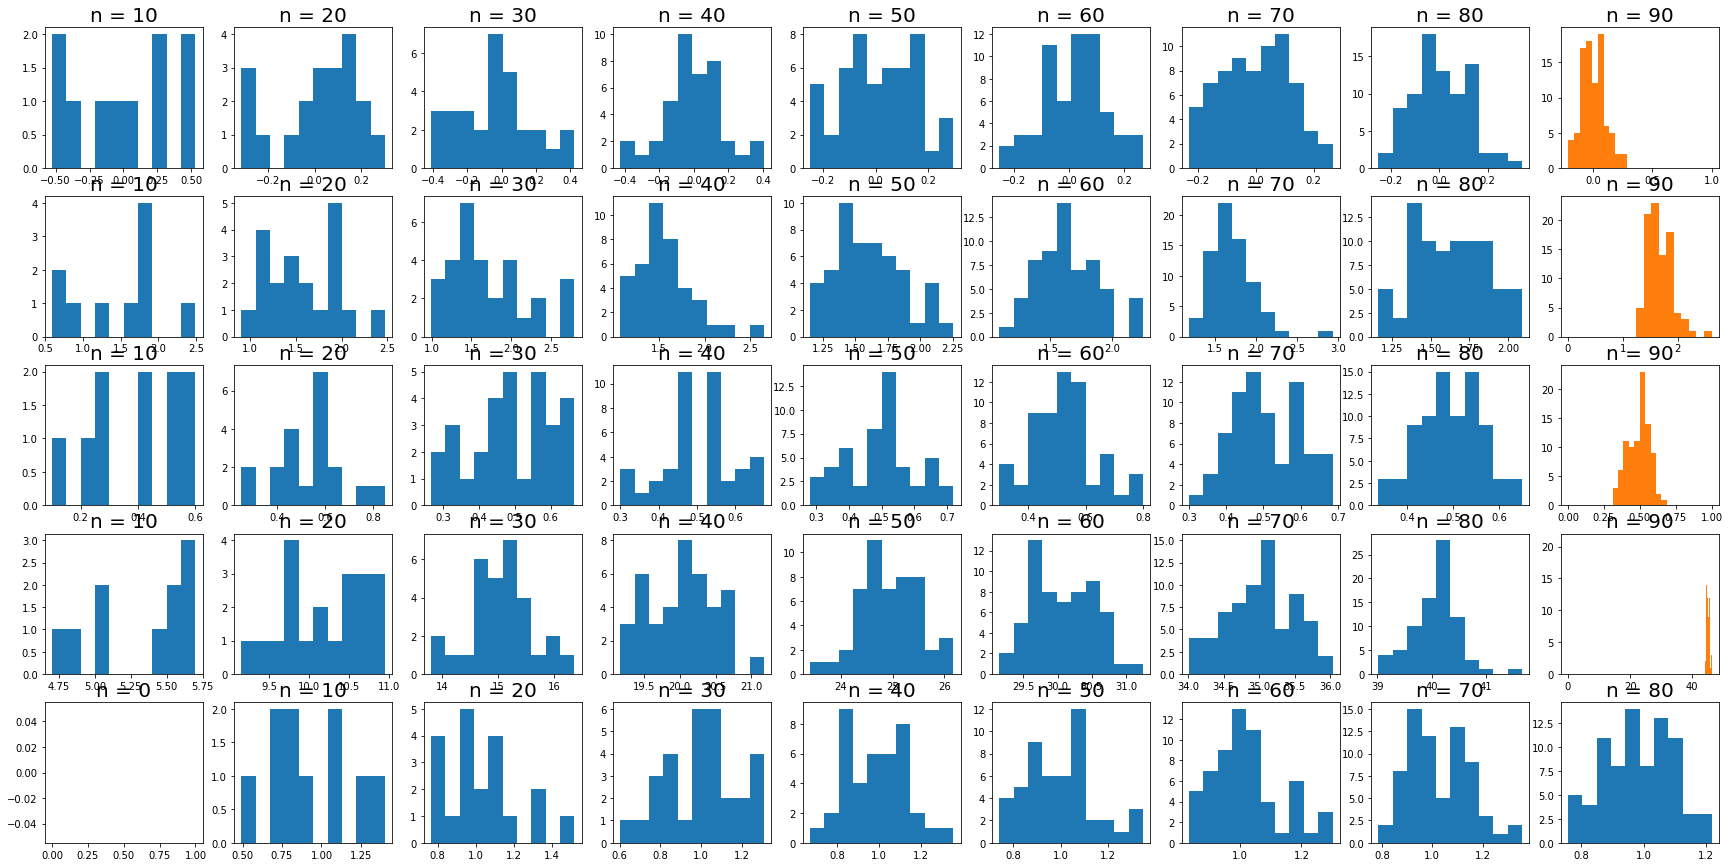

In [11]:
from datlib import distributions
import scipy.stats as st 

fig, ax = plt.subplots(5, 9, figsize = (30, 15))

for n in range(0, 100, 10):
    x_spot = int((n/10)-1)
    means_list = []
    for x in range(n):
        mean = np.random.normal(0, 1, size = n).mean()
        means_list.append(mean)
        
    ax[0, x_spot].set_title("n = "+str(n), fontsize = 20)
    ax[0, x_spot].hist(means_list, bins=10)
    
    
for n in range(0, 100, 10):
    x_spot = int((n/10)-1)
    means_list = []
    for x in range(n):
        mean = np.random.lognormal(0, 1, size = n).mean()
        means_list.append(mean)
    ax[1, x_spot].set_title("n = "+str(n), fontsize = 20)
    ax[1, x_spot].hist(means_list, bins=10)
    
for n in range(0, 100, 10):
    x_spot = int((n/10)-1)
    means_list = []
    for x in range(n):
        mean = np.random.poisson(0.5, size = n).mean()
        means_list.append(mean)
    ax[2, x_spot].set_title("n = "+str(n), fontsize = 20)
    ax[2, x_spot].hist(means_list, bins=10)
    
for n in range(0, 100, 10):
    x_spot = int((n/10)-1)
    means_list = []
    for x in range(n):
        mean = np.random.binomial(n=n, p=0.5, size = n).mean()
        means_list.append(mean)
        
    ax[3, x_spot].set_title("n = "+str(n), fontsize = 20)
    ax[3, x_spot].hist(means_list, bins=10)
    
for n in range(0, 90, 10):
    x_spot = int((n/10))
    means_list = []
    for x in range(n):
        mean = np.random.exponential(1, size = n).mean()
        means_list.append(mean)
        
    ax[4, x_spot].set_title("n = "+str(n), fontsize = 20)
    ax[4, x_spot].hist(means_list, bins=10)
  


So, for any sample with $n$ > 30, $\bar{x}$ can be substituted for $\mu$ and $s$ can be substituted for $\sigma$
 
This Z-test asunes that we have access to the population standard deviation and mean _or_ that $n$ is large enough (>30) for $s^2$ and $\bar{x}$ to be used as a reliable estimate for $\sigma^2$ and $\mu$. When these conditions do not hold, and we do not have a large enough sample or sufficient population data, we need another estimator.  
 

The __T-test__ is used when we are dealing with a population of unknown distribution, and would like to compare a given sample mean to one of three options: 

- **One Sample T-test:** The one sample t test compares the mean of your sample data to a known value. For example, you might want to know how your sample mean compares to the population mean, like our value of 120,000 for average mothly store revenue
<h3 align="center">
    <font size="7">
        $ t = \frac{\bar{X} - \mu}{\frac{s}{\sqrt{n}}}$
    </font>
    </h3> 
    
    - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
    - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean
    

- **Independent Samples T-test:** The The independent samples t test (also called the unpaired samples t test) is the most common form of the T test. It helps you to compare the means of two sets of data. Normally, we are checking to see if the means of the data are significantly different from a differnece of zero. But , we can also check if they are significantly different from a hypothesized or theoretical value. For instance, say we had two groups of males and one group of females and we wanted to compare average heights between the groups. For the males, we would check to see if they differed significantly from an average height difference of zero, whereas when comparing the males to the females we may want to see if they were significantly different from an average difference of 2 inches, or whatever the average height between males and females is. **This hypothesized difference, $(\mu_1 - \mu_2)$, will usually be zero, but not always.**

<h3 align="center">
    <font size="7">
        $ t = \frac{(\bar{x_1}-\bar{x_2})-(\mu_1 - \mu_2)}{\sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}}$
    </font>
    </h3> 
    
   
   - Note that this t-test is one variation of the independent samples t-test that _does not_ assume equal variance between the samples
   
    - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
    - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean
    
    
- **Paired Samples T-test:** A paired t test (also called a correlated pairs t-test, a paired samples t test or dependent samples t test) is where you run a t test on dependent samples. Dependent samples are essentially connected — they are tests on the same person or thing. This would be useful if we chose a random sample of stores and measured their mean revenues before and after implementation of the new marketing campaign as our two means. For ths test, new terms are used, $\bar{d}$,  $\delta$, and $s_d$. $\bar{d}$ represents the average difference between $x_i1$ and $x_i2$, $s_d$ is the standard error of $\bar{d}$, and  $\delta$ is the hypothesized difference value being tested between the two means. It is usually 0.  
<h3 align="center">
    <font size="10">
        $ t = \frac{\bar{d} - \delta}{\frac{s_d}{\sqrt{n}}}$
    </font>
    </h3> 
    
Where...
<h3 align="center">
    <font size="3">
        $ \bar{d} = \sum_{i=1}^{n} d_i$
    </font>
    </h3> 
And...
<h3 align="center">
    <font size="3">
        $ s_d = \sqrt{\frac{\sum_{i=1}^{n} (d_i-\bar{d})^2}{n-1}}$
    </font>
    </h3> 
    
The t-value we obtain will lie on the horizontal axis of our t-distribution, representing the number of standard deviations the difference between our sample mean and theoretical mean lies from zero, with a corresponding p-value on the y-axis that tells us how likely our result would be if the population our sample was drawn from had the same mean as our theorized or population mean. This t-distribution takes the form: 
<h3 align="center">
    <font size="6">
        $ f(x) = \frac{(1 + \frac{x^2}{\nu})^{\frac{-(\nu+1)}{2}}}{B(0.5,0.5\nu)\sqrt(\nu)}$
    </font>
    </h3> 
    
    
- Where $\nu$ is the degrees of freedom of the distribution and B is the beta function, which is beyond the scope of this book and can be pulled from the scipy.stats library. 

We now implement the theory into code: 

First, we create a funtion that uses a flat np.linspace array from -10 to 10(very extreme t vaues) and transform it according to the t-distributions density function:

In [12]:
import datlib.stats
import scipy.special as sc

# define a function to create the actual distribution from which we can analyze our t value from the t test
# must pass an array of x values with customized length and density; usually done with np.linspace()
def t_distribution(x, df):
    x = np.linspace(-5, 5, 1000) # large number of points will ensure accuracy
    # transform flat array of x values into t distribution
    t_distribution = ((1+x**2/df)**(-(df+1)/2))/(sc.beta(.5, .5*df)*np.sqrt(df))
    return t_distribution

Next, we create a function that will calculate a t value from a given sample set and $\mu$ value and output the t value and its corresponding p-value from the distribution we created. 

<h3 align="center">
    <font size="7">
        $ t = \frac{\bar{X} - \mu}{\frac{s}{\sqrt{n}}}$
    </font>
    </h3> 

In [13]:
def ttest_one_sample(data, mu):
    x_bar = mean(data)
    s = SD(data, sample=True)
    n = len(data)
    df = n - 1
    t = (x_bar - mu) / (s / np.sqrt(n))
    p_value = ((1 + t**2 / df)**(-(df + 1) / 2)) / (sc.beta(.5, .5 * df) * np.sqrt(df))
    if p_value > .05:
        return_string = "T-value: " + str(t) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
    else:
        return_string = "T-value: " + str(t) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."

    return return_string

To show the utility of the single-sample t-test, we can check to see if the S&P500's average yearly return was significantly different from some arbitrary value, like 10%. Can we confidently say that the S&P500's return was different from 10%, or could the observed difference have been due to random variation? 

In [14]:
mean(sp500)

TypeError: 'numpy.float64' object is not callable

In [ ]:
ttest_one_sample(sp500, .10)

From the test, we fail to reject our null hypothesis that the average yearly S&P500 gain was not significantly different from 10%. 

<h3 align="center">
    <font size="7">
        $ t = \frac{(\bar{x_1}-\bar{x_2})-(\mu_1 - \mu_2)}{\sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}}$
    </font>
    </h3> 

In [ ]:
def ttest_ind_samp_timeseries(a, b, hypothesized_difference = 0): 
    s1 = variance(a)
    s2 = variance(b)
    x_bar1 = mean(a)
    x_bar2 = mean(b)
    n1 = len(a)
    n2 = len(b)
    df = ((s1 / n1 + s2 / n2)**2) / ((1 / n1 - 1)*(s1 / n1)**2 + (1 / n2 - 1)*(s2 / n2)**2)
    df_approx = abs(df.round(0))
    t = ((x_bar1 - x_bar2) - (hypothesized_difference)) / (np.sqrt( (s1 / n1) + ( s2 / n2)))
    p_value = ((1 + t**2 / df_approx)**(-(df_approx + 1) / 2)) / (sc.beta(.5, .5 * df) * np.sqrt(df_approx))
    if p_value > .05:
        return_string = "T-value: " + str(t) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
    else:
        return_string = "T-value: " + str(t) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."

    return return_string
    
    

In [ ]:
t = -5 
abs(t)


In [ ]:
for key in yearly_returns_dict.keys():
    print("\n"+key+": ")
    print(ttest_ind_samp_timeseries(yearly_returns_dict[key], sp500))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
cauchy = create_t_distribution(1)
ax.plot(cauchy, '-', lw=3, alpha=1,  label = "Cauchy", color='b')
t_df = [2, 3, 4, 5, 10, 20]
for df in t_df:
    dist = create_t_distribution(df)
    ax.plot(dist, '-', lw=1, alpha=df/20,  label = "df: "+ str(df), color='k')
gaussian = create_t_distribution(30)
ax.plot(gaussian, lw=3, alpha=1, color = 'r',  label='Standard Normal Distribution')
plt.rcParams.update({"font.size": 15})
ax.set_ylabel("Probability of t-score")
ax.set_xlabel("Standard Deviations away from mean( this varies as the distributions have different SD's)")
plt.title("T-distribution with varying degrees of freedom")
ax.set_xticklabels(labels = "")
plt.legend()

### T-distribution p-value

As we can see, a lower sample size, and hence a lower degrees of freedom, leads to a lower probaility that our t-score is near 0 when our population means are the same, because more random variation is likely when the sample size is so low. The point of a t-score is to determine if the difference in the two means of the samples is too drastic for the true population means to be the same. As we approacch 30 with our degrees of freedom, the graph doesnt change much, and this is a standard normal distribution, which the z-score uses. That is why we use z-score for large sample sizes. 

Once we get our t-score based on the t-distribution, shown on the x-axis of the above graph, we get a corresponding __p-value__, shown on the y-axis. This value is the probability of our gotten t-value if the true means were the same. 

- If the corresponding p-value from our t-value is too low, we choose to __reject the null hypothesis $H_o$__, and say that our samples come from different populations who's means are different. This is a "statistically significant" result. 


- If the p-value is sufficiently high, we __fail to reject the null hypothesis $H_o$__, and say that there is a high enough chance that the samples came from populations with the same means. This is a "statistically insignificant" result. 


- The value at which a non-significant result becomes a significant one is called the __*critical value*__, denoted $\alpha$, and is most commonly 0.05. For a two-tailed t-test, where we want to know if one sample is either significantly higher or lower than the other, we will choose to reject $H_o$ if our t-value falls within the outer 2.5% of our distribution(.025*2 = .05), which would result in a p-value of less thanm .05 for a two-tailed t-test. 

Let's return to our example of company starting salary to see if we can make an educated inference about whether or not one company actually has a higher starting salary than the other. 

# ANOVA 